In [1]:
%load_ext autoreload
%autoreload 2

import torch
import torchvision.models as models
from util.EnsembleModelController import EnsembleController
from util.misc_functions import float2rgb
from dataset.hvm import HVMDataset
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

# load up target and source models
squeezenet1 = models.squeezenet1_1(pretrained=True).features
squeezenet0 = models.squeezenet1_0(pretrained=True).features
alexnet = models.alexnet(pretrained=True).features
vgg16 = models.vgg16(pretrained=True).features
resnet = torch.nn.Sequential(*list(models.resnet18(pretrained=True).children()))
densenet = models.densenet161(pretrained=True).features
inception = torch.nn.Sequential(*list(models.inception_v3(pretrained=True).children())[:-3])
mobilenet = models.mobilenet_v2(pretrained=True).features
googlenet = torch.nn.Sequential(*list(models.googlenet(pretrained=True).children())[:-3])

# package as input to the controller
#nets = [inception, googlenet, mobilenet, squeezenet1, squeezenet0, vgg16, resnet, alexnet]
#labels = ['inception','googlenet', 'mobilenet', 'squeeze1_1','squeeze1_0','vgg16','resnet18','alexnet']
#layers = [11,16,19,13,13,30,8,13]
#n_models = len(labels)
nets = [mobilenet, squeezenet1, vgg16, resnet, alexnet]
labels = ['mobilenet', 'squeeze1_1','vgg16','resnet18','alexnet']
layers = [19,13,30,8,13]
n_models = len(labels)

# load dataset
n_data = 5500;
n_train = 4000;
n_test = 1500;
n_targets = 200;
hvmdataset = HVMDataset('cpu',n_data, shuffle = True)
# load images for A-Clamp
n_clamp = 500;
hvmclampset = HVMDataset('cpu', n_data, n_train, n_test, n_clamp, shuffle = True, subset = 'clamp')

Using device: cuda
loading and preprocessing hvm


100%|█████████████████████████████████████████████████████████████████████████████| 5500/5500 [00:17<00:00, 320.23it/s]


loading and preprocessing hvm


100%|████████████████████████████████████████████████████████████████████████████| 5500/5500 [00:01<00:00, 3617.37it/s]


In [2]:
n_set = 20 
wrs = [.1, .3, 1, 3, 10, 30, 100, 300, 1000]
# create ensemble controller
EC1 = EnsembleController(nets,layers,labels,device)
EC1.design(hvmdataset, batch_size = 10)
EC1.train_test_subset(n_train,n_test,n_targets)

Extracting activations


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:27<00:00, 15.81s/it]


In [3]:
train_scr = np.zeros((len(wrs),n_models, n_targets))
test_scr = np.zeros((len(wrs),n_models, n_targets))
train_e_scr = np.zeros((len(wrs),n_models, n_targets))
test_e_scr = np.zeros((len(wrs),n_models, n_targets))

w_L1 = np.zeros((len(wrs),n_models, n_targets))
w_L2 = np.zeros((len(wrs),n_models, n_targets))

clamp_df = np.zeros((len(wrs),n_models, n_set,2))
clamp_sd = np.zeros((len(wrs),n_models, n_set,2))
clamp_scr = np.zeros((len(wrs),n_models, n_set))
opt_scr = np.zeros((len(wrs),n_models, n_set))

clamp_e_df = np.zeros((len(wrs),n_models, n_set,2))
clamp_e_sd = np.zeros((len(wrs),n_models, n_set,2))
clamp_e_scr = np.zeros((len(wrs),n_models, n_set))
opt_e_scr = np.zeros((len(wrs),n_models, n_set))
for i, wr in enumerate(wrs):
    print(f'Weight regularizer: {wr}')
    EC1.fit(option = 'TR', label = f'_wr{wr}', w_reg = wr, load = True)
    EC1.score_models()
    EC1.score_ensembles()
    EC1.get_surrogate()
    # projected A-clamp with indivisual models and with ensemble
    EC1.design_proj_clamp(hvmclampset, epsilon = 10, n_sets = n_set, set_size = 40)
    EC1.proj_ensemble_clamp(hvmclampset,lr = .05,wd = 1e-3,n_iter = 10)
    #EC1.proj_model_clamp(lr = .05, wd = 1e-3, n_iter = 10)
    
    EC1.proj_clamp_score(model_eval = False)
    for n in range(n_models):
        train_scr[i,n] = EC1.models[n]['train_score']
        test_scr[i,n] = EC1.models[n]['test_score']
    #    w_L1[i,n] = torch.linalg.norm(EC1.tensor_w[n].cpu().mean(axis=1).mean(axis=1),ord =1, dim = 0).numpy()
    #    w_L2[i,n] = torch.linalg.norm(EC1.tensor_w[n].cpu().mean(axis=1).mean(axis=1),ord =2, dim = 0).numpy()
    #    clamp_scr[i,n] = EC1.models[n]['ctr_p_score']
    #    opt_scr[i,n] = EC1.models[n]['opt_p_score']
    #    for s in range(n_set):
    #        pidx = EC1.models[n]['sur_p_eps'][:,s]>0
    #        nidx = EC1.models[n]['sur_p_eps'][:,s]<0
    #        clamp_df[i,n,s,0] = np.mean(EC1.models[n]['tar_p_obs'][nidx,s].numpy())
    #        clamp_sd[i,n,s,0] = np.std(EC1.models[n]['tar_p_obs'][nidx,s].numpy())
    #        clamp_df[i,n,s,1] = np.mean(EC1.models[n]['tar_p_obs'][pidx,s].numpy())
    #        clamp_sd[i,n,s,1] = np.std(EC1.models[n]['tar_p_obs'][pidx,s].numpy())
    for n in range(n_models-1):
        train_e_scr[i,n] = EC1.ensemble['train_score'][:,:,n].mean(axis = 1)
        test_e_scr[i,n] = EC1.ensemble['test_score'][:,:,n].mean(axis = 1)
        clamp_e_scr[i,n] = EC1.ensemble['ctr_p_score']
        opt_e_scr[i,n] = EC1.ensemble['opt_p_score']
        for s in range(n_set):
            pidx = EC1.ensemble['sur_p_eps'][:,s]>0
            nidx = EC1.ensemble['sur_p_eps'][:,s]<0
            clamp_e_df[i,n,s,0] = np.mean(EC1.ensemble['tar_p_obs'][nidx,s].numpy())
            clamp_e_sd[i,n,s,0] = np.std(EC1.ensemble['tar_p_obs'][nidx,s].numpy())
            clamp_e_df[i,n,s,1] = np.mean(EC1.ensemble['tar_p_obs'][pidx,s].numpy())
            clamp_e_sd[i,n,s,1] = np.std(EC1.ensemble['tar_p_obs'][pidx,s].numpy())

Weight regularizer: 0.1
Projected A-Clamping with ensemble(x4)


100%|██████████████████████████████████████████████████████████████████████████████| 250/250 [1:46:58<00:00, 25.67s/it]


Weight regularizer: 0.3
Projected A-Clamping with ensemble(x4)


100%|██████████████████████████████████████████████████████████████████████████████| 250/250 [1:47:10<00:00, 25.71s/it]


Weight regularizer: 1
Projected A-Clamping with ensemble(x4)


100%|██████████████████████████████████████████████████████████████████████████████| 250/250 [1:47:10<00:00, 25.73s/it]


Weight regularizer: 3
Projected A-Clamping with ensemble(x4)


100%|██████████████████████████████████████████████████████████████████████████████| 250/250 [1:47:09<00:00, 25.71s/it]


Weight regularizer: 10
Projected A-Clamping with ensemble(x4)


100%|██████████████████████████████████████████████████████████████████████████████| 250/250 [1:47:13<00:00, 25.73s/it]


Weight regularizer: 30
Projected A-Clamping with ensemble(x4)


100%|██████████████████████████████████████████████████████████████████████████████| 250/250 [1:49:00<00:00, 25.76s/it]


Weight regularizer: 100
Projected A-Clamping with ensemble(x4)


100%|██████████████████████████████████████████████████████████████████████████████| 250/250 [1:47:23<00:00, 25.76s/it]


Weight regularizer: 300
Projected A-Clamping with ensemble(x4)


100%|██████████████████████████████████████████████████████████████████████████████| 250/250 [1:48:14<00:00, 25.75s/it]


Weight regularizer: 1000
Projected A-Clamping with ensemble(x4)


100%|██████████████████████████████████████████████████████████████████████████████| 250/250 [1:49:19<00:00, 25.79s/it]


In [ ]:
#savedict = {'train_scr':train_scr, 'test_scr':test_scr,'w_L1':w_L1,'w_L2':w_L2,'clamp_df':clamp_df,'clamp_sd':clamp_sd,'clamp_scr':clamp_scr,'opt_scr':opt_scr}
#torch.save(savedict,'params\\weight_reg_sweep019821.pt')

In [4]:
# can load from here if just want to play with illustrations'
#import torch
#import seaborn as sns
#import matplotlib.pyplot as plt
#import numpy as np
#labels = ['mobilenet', 'squeeze1_1','vgg16','resnet18','alexnet']
#n_models = len(labels)
#wrs = [.1, .3, 1, 3, 10, 30, 100, 300, 1000]

loaddict = torch.load('params\\weight_reg_sweep019821.pt')
train_scr = loaddict['train_scr']
test_scr = loaddict['test_scr']
w_L1 = loaddict['w_L1']
w_L2 = loaddict['w_L2']
clamp_df = loaddict['clamp_df']
clamp_sd = loaddict['clamp_sd']
clamp_scr = loaddict['clamp_scr']
opt_scr = loaddict['opt_scr']

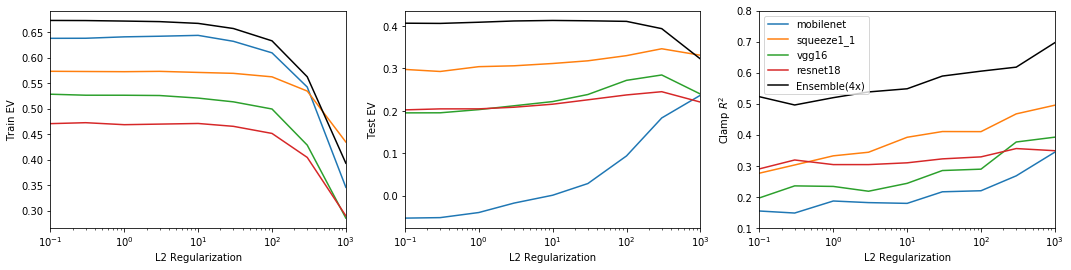

In [22]:
plt.figure(figsize=(18,4))
plt.subplot(1,3,1)
plt.semilogx(wrs,np.mean(train_scr[:,:-1,:],axis=2))
plt.semilogx(wrs,np.mean(train_e_scr[:,-2,:],axis=1),'k')
plt.xlabel('L2 Regularization')
plt.ylabel('Train EV')
plt.xlim([wrs[0],wrs[-1]])
plt.subplot(1,3,2)
plt.semilogx(wrs,np.mean(test_scr[:,:-1,:],axis=2))
plt.semilogx(wrs,np.mean(test_e_scr[:,-2,:],axis=1),'k')
plt.xlabel('L2 Regularization')
plt.ylabel('Test EV')
plt.xlim([wrs[0],wrs[-1]])
plt.subplot(1,3,3)
for n in range(n_models-1):
    plt.semilogx(wrs,np.mean(clamp_scr[:,n,:],axis=1),label = labels[n])
plt.semilogx(wrs,np.mean(clamp_e_scr[:,-2,:],axis=1),'k',label = 'Ensemble(4x)')
plt.xlabel('L2 Regularization')
plt.ylabel(r'Clamp $R^2$')
plt.ylim([0.1,.8])
plt.xlim([wrs[0],wrs[-1]])
plt.legend()
plt.show()

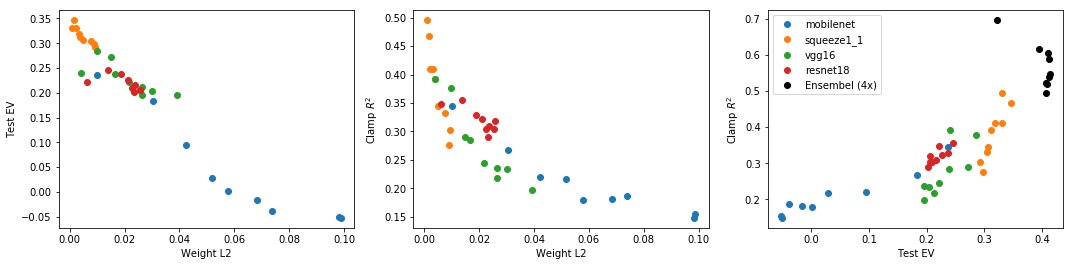

In [42]:
x_data = w_L2[:-1,:-1,:].mean(axis = 2).flatten()
y_data = test_scr[:-1,:-1,:].mean(axis = 2).flatten()
curve_fit = np.polyfit(x_data, y_data, 1)
xfit1 = np.arange(-.1,.1,.001)
yfit1 = curve_fit[1]+xfit1*curve_fit[0]

x_data = w_L2[:,:-1,:].mean(axis = 2).flatten()
log_y_data = np.log(clamp_scr[:,:-1,:].mean(axis = 2).flatten())
curve_fit = np.polyfit(x_data, log_y_data, 1)
xfit2 = np.arange(-.1,.1,.001)
yfit2 = np.exp(curve_fit[1]+xfit2*curve_fit[0])

x_data = test_scr[:,:-1,:].mean(axis = 2).flatten()
log_y_data = np.log(clamp_scr[:,:-1,:].mean(axis = 2).flatten())
curve_fit = np.polyfit(x_data, log_y_data, 1)
xfit3 = np.arange(-.1,.4,.01)
yfit3 = np.exp(curve_fit[1])*np.exp(xfit3*curve_fit[0])

plt.figure(figsize=(18,4))
for n in range(n_models-1):
    plt.subplot(1,3,1)
    plt.plot(np.mean(w_L2[:,n,:],axis=1),np.mean(test_scr[:,n,:],axis=1),'o')
    plt.xlabel('Weight L2')
    plt.ylabel('Test EV')
    plt.subplot(1,3,2)
    plt.plot(np.mean(w_L2[:,n,:],axis=1),np.mean(clamp_scr[:,n,:],axis=1),'o')
    plt.xlabel('Weight L2')
    plt.ylabel(r'Clamp $R^2$')
    plt.subplot(1,3,3)
    plt.plot(np.mean(test_scr[:,n,:],axis=1),np.mean(clamp_scr[:,n,:],axis=1),'o',label = labels[n])
    plt.xlabel('Test EV')
    plt.ylabel(r'Clamp $R^2$')
    
plt.subplot(1,3,3)
plt.plot(np.mean(test_e_scr[:,-2,:],axis=1),np.mean(clamp_e_scr[:,-2,:],axis=1),'ko',label = 'Ensembel (4x)')
    
#plt.subplot(1,3,1)
#plt.plot(xfit1,yfit1,'k--')
#plt.subplot(1,3,2)
#plt.plot(xfit2,yfit2,'k--')
#plt.subplot(1,3,3)
#plt.plot(xfit3,yfit3,'k--')
plt.legend()
plt.show()

In [ ]:
import seaborn as sns

gaussfit = lambda x,mu,sig: 1./(np.sqrt(2.*np.pi)*sig)*np.exp(-np.power((x - mu)/sig, 2.)/2)
eps = 10
mad = lambda x: np.median(abs(x-np.median(x)))

samp_set = [9]
plt.figure(figsize=(18,4*(EC1.n_models-1)))
for n in range(EC1.n_models-1):
    # show example of single neuron activity clamp
    pidx = EC1.models[n]['sur_p_eps'][:,samp_set[0]]>2
    nidx = EC1.models[n]['sur_p_eps'][:,samp_set[0]]<-1
    p_sur_obs = EC1.models[n]['sur_p_obs'].numpy()[pidx,samp_set[0]]
    n_sur_obs = EC1.models[n]['sur_p_obs'].numpy()[nidx,samp_set[0]]
    plt.subplot(EC1.n_models-1,3,2+n*3)
    xdelta = .2
    xbin = np.arange(-eps-2,eps+2,xdelta)
    sns.histplot(p_sur_obs,bins = xbin,color='b',label=r'$\epsilon = +100$')
    sns.histplot(n_sur_obs,bins = xbin,color='r',label=r'$\epsilon = -100$')
    plt.plot(xbin, gaussfit(xbin,np.median(n_sur_obs),np.std(n_sur_obs))*len(p_sur_obs)*xdelta,'r-')
    plt.plot(xbin, gaussfit(xbin,np.median(p_sur_obs),np.std(p_sur_obs))*len(p_sur_obs)*xdelta,'b-')
    plt.plot([0,0],[0,1000],'k--')
    plt.ylim((0,n_clamp/5))
    plt.xlabel(r'$|\delta f^{\ surrogate}|$',fontsize = 18)
    plt.ylabel(r'# images',fontsize = 18)
    legend = plt.legend(fontsize = 18, title=EC1.models[n]['id'])
    legend.get_title().set_fontsize('18')
    
    p_tar_obs = EC1.models[n]['tar_p_obs'].numpy()[pidx,samp_set[0]]
    n_tar_obs = EC1.models[n]['tar_p_obs'].numpy()[nidx,samp_set[0]]
    plt.subplot(EC1.n_models-1,3,3+n*3)
    xdelta3 = .2
    xbin3 = np.arange(-eps,eps,xdelta3)
    sns.histplot(p_tar_obs,bins = xbin3,color='b',label=r'$\epsilon = +100$')
    sns.histplot(n_tar_obs,bins = xbin3,color='r',label=r'$\epsilon = -100$')
    plt.plot(xbin3, gaussfit(xbin3,np.median(n_tar_obs),np.std(n_tar_obs))*len(p_sur_obs)*xdelta3,'r-')
    plt.plot(xbin3, gaussfit(xbin3,np.median(p_tar_obs),np.std(p_tar_obs))*len(p_sur_obs)*xdelta3,'b-')
    plt.plot([0,0],[0,1000],'k--')
    plt.ylim((0,n_clamp/10))
    plt.xlim([-eps/2, eps/2])
    plt.xlabel(r'$|\delta f^{\ target}|$',fontsize = 18)
    plt.ylabel(r'# images',fontsize = 18)

    p_dx = EC1.models[n]['p_dx'].numpy()[pidx,samp_set[0]]
    n_dx = EC1.models[n]['p_dx'].numpy()[nidx,samp_set[0]]
    plt.subplot(EC1.n_models-1,3,1+n*3)
    xdelta1 = 2
    xbin1 = np.arange(0,eps*20,xdelta1)
    sns.histplot(p_dx,bins = xbin1,color='b',label=r'$\epsilon = +100$')
    sns.histplot(n_dx,bins = xbin1,color='r',label=r'$\epsilon = -100$')
    plt.plot(xbin1, gaussfit(xbin1,np.median(n_dx),np.std(n_dx))*len(p_sur_obs)*xdelta1,'r-')
    plt.plot(xbin1, gaussfit(xbin1,np.median(p_dx),np.std(p_dx))*len(p_sur_obs)*xdelta1,'b-')
    plt.plot([0,0],[0,1000],'k--')
    plt.ylim((0,n_data/40))
    plt.xlabel(r'$|\delta x|$',fontsize = 18)
    plt.ylabel(r'# images',fontsize = 18)
plt.show()